In [2]:
from google.colab import files
uploaded = files.upload()  # Upload: monthly ev sales 16-25.xlsx

import pandas as pd

ev_df = pd.read_excel("monthly ev sales 16-25.xlsx")
ev_df['Date'] = pd.to_datetime(ev_df['Months'], format='%b %y', errors='coerce')
ev_df = ev_df.rename(columns={'sales': 'EV_Sales'})[['Date', 'EV_Sales']]
ev_df.head()


Saving monthly ev sales 16-25.xlsx to monthly ev sales 16-25.xlsx


,Date,EV_Sales
0,2016-01-01,584
1,2016-02-01,239
2,2016-03-01,2341
3,2016-04-01,580
4,2016-05-01,517


In [3]:
from google.colab import files
uploaded = files.upload()  # Upload: public charging points by quarter 20152024.xlsx

# Load and clean charger data
charger_df = pd.read_excel("public charging points by quarter 20152024.xlsx")
charger_df.columns = ["Quarter", "ChargerCount"]
charger_df["Date"] = pd.to_datetime(charger_df["Quarter"], errors="coerce")
charger_df = charger_df[["Date", "ChargerCount"]].dropna()

# Resample to monthly frequency using forward fill
charger_monthly = charger_df.set_index('Date').resample('MS').ffill().reset_index()

# Preview charger data
charger_monthly.head()


Saving public charging points by quarter 20152024.xlsx to public charging points by quarter 20152024.xlsx


/tmp/ipython-input-3-211266827.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  charger_df["Date"] = pd.to_datetime(charger_df["Quarter"], errors="coerce")


,Date,ChargerCount
0,2015-04-01,2664
1,2015-05-01,2664
2,2015-06-01,2664
3,2015-07-01,2910
4,2015-08-01,2910


In [4]:
from google.colab import files
uploaded = files.upload()  # Upload: EV_Charging_Grant_Sheet1_Cleaned.xlsx

# Load and clean grant data
grant_df = pd.read_excel("EV_Charging_Grant_Sheet1_Cleaned.xlsx")
grant_df['Date'] = pd.to_datetime(grant_df['Date'], errors='coerce')
grant_df['GrantStatus'] = grant_df['Total_GrantValue'].apply(lambda x: 1 if x > 0 else 0)
grant_df = grant_df[['Date', 'GrantStatus']]

# Preview grant data
grant_df.head()


Saving EV_Charging_Grant_Sheet1_Cleaned.xlsx to EV_Charging_Grant_Sheet1_Cleaned.xlsx


,Date,GrantStatus
0,2022-03-01,1
1,2022-04-01,1
2,2022-05-01,1
3,2022-06-01,1
4,2022-07-01,1


In [13]:
from google.colab import files
uploaded = files.upload()  # Re-upload: Monthly diesel fuel price in the UK 2020-2024.xlsx

# Load and parse 'Months' as datetime using format='%b %y'
fuel_df = pd.read_excel("Monthly diesel fuel price in the UK 2020-2024.xlsx")
fuel_df.columns = fuel_df.columns.str.strip()
fuel_df = fuel_df.rename(columns={fuel_df.columns[0]: "Date", fuel_df.columns[1]: "FuelPrice"})
fuel_df['Date'] = pd.to_datetime(fuel_df['Date'], format='%b %y', errors='coerce')
fuel_df = fuel_df[['Date', 'FuelPrice']]

fuel_df.head()


Saving Monthly diesel fuel price in the UK 2020-2024.xlsx to Monthly diesel fuel price in the UK 2020-2024 (3).xlsx


,Date,FuelPrice
0,NaT,Supermarket average
1,2020-01-01,129.4
2,2020-02-01,123.2
3,2020-03-01,119
4,2020-04-01,110.8


In [15]:
import statsmodels.api as sm
import pandas as pd

# Step 1: Merge datasets step-by-step
# Ensure fuel_df has only numeric FuelPrice before merging
fuel_df = fuel_df[pd.to_numeric(fuel_df['FuelPrice'], errors='coerce').notna()].copy()
df = pd.merge(ev_df, fuel_df, on='Date', how='left')
df = pd.merge(df, charger_monthly, on='Date', how='left')
df = pd.merge(df, grant_df, on='Date', how='left')


# Step 2: Clean missing data and ensure correct data types
df['GrantStatus'] = df['GrantStatus'].fillna(0).astype(int)
# Convert to numeric before interpolation
df['FuelPrice'] = pd.to_numeric(df['FuelPrice'], errors='coerce')
df['ChargerCount'] = pd.to_numeric(df['ChargerCount'], errors='coerce')

# Interpolate remaining missing values
df['FuelPrice'] = df['FuelPrice'].interpolate()
df['ChargerCount'] = df['ChargerCount'].interpolate()


# Step 3: Keep only rows where EV sales are present and drop any remaining NaNs in the model columns
mlr_df = df.dropna(subset=['EV_Sales', 'FuelPrice', 'ChargerCount', 'GrantStatus'])

# Step 4: Define model inputs
X = mlr_df[['FuelPrice', 'ChargerCount', 'GrantStatus']]
y = mlr_df['EV_Sales']
X = sm.add_constant(X)  # Add intercept

# Step 5: Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               EV_Sales   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     10.51
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           1.57e-05
Time:                        09:27:58   Log-Likelihood:                -605.13
No. Observations:                  57   AIC:                             1218.
Df Residuals:                      53   BIC:                             1226.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4395.2648   1.33e+04     -0.330   

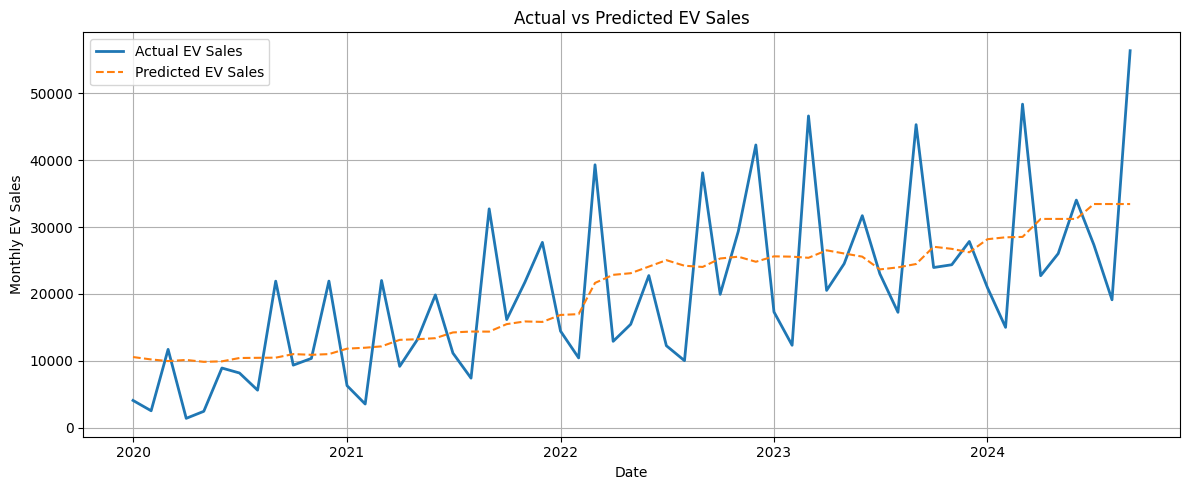

In [16]:
import matplotlib.pyplot as plt

# Generate predictions
mlr_df['Predicted_EV_Sales'] = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(mlr_df['Date'], mlr_df['EV_Sales'], label='Actual EV Sales', linewidth=2)
plt.plot(mlr_df['Date'], mlr_df['Predicted_EV_Sales'], label='Predicted EV Sales', linestyle='--')
plt.title('Actual vs Predicted EV Sales')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


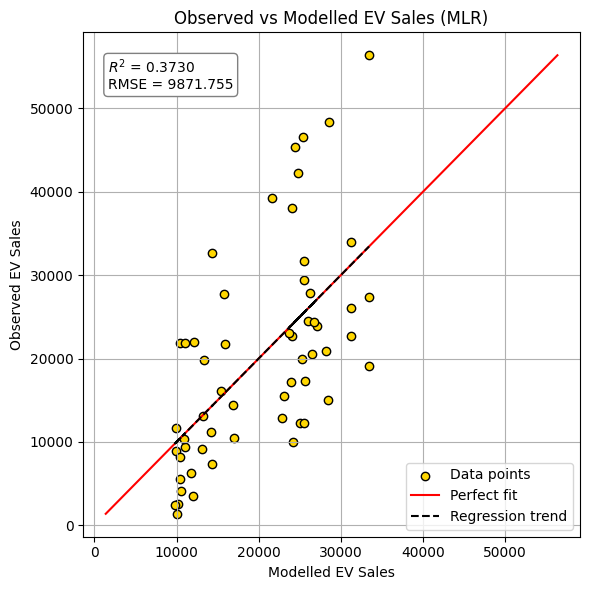

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Predicted values from your model
y_pred = model.predict(X)
y_true = y  # actual observed values

# Plot setup
plt.figure(figsize=(6, 6))
plt.scatter(y_pred, y_true, color='gold', edgecolor='black', label='Data points')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='-', label='Perfect fit')

# Regression fit line
z = np.polyfit(y_pred, y_true, 1)
p = np.poly1d(z)
plt.plot(y_pred, p(y_pred), 'k--', label='Regression trend')

# Metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Calculate RMSE manually
plt.text(0.05, 0.95, f'$R^2$ = {r2:.4f}\nRMSE = {rmse:.3f}', transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle="round", fc="white", ec="gray"))

# Labels and legend
plt.xlabel('Modelled EV Sales')
plt.ylabel('Observed EV Sales')
plt.title('Observed vs Modelled EV Sales (MLR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()